Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or elise or stephan, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [1]:
NAMES = "Andrei Marius Sili"

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [3]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

Type:        GridworldEnv
String form: <GridworldEnv instance>
File:        ~/Code/AI/rl-labs/lab1/gridworld.py
Docstring:  
Grid World environment from Sutton's Reinforcement Learning book chapter 4.
You are an agent on an MxN grid and your goal is to reach the terminal
state at the top left or the bottom right corner.

For example, a 4x4 grid looks as follows:

T  o  o  o
o  x  o  o
o  o  o  o
o  o  o  T

x is your position and T are the two terminal states.

You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
Actions going off the edge leave you in your current state.
You receive a reward of -1 at each step until you reach a terminal state.


In [4]:
# To have a quick look into the code
??env

Type:        GridworldEnv
String form: <GridworldEnv instance>
File:        ~/Code/AI/rl-labs/lab1/gridworld.py
Source:     
class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.

    For example, a 4x4 grid looks as follows:

    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T

    x is your position and T are the two terminal states.

    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[4,4]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [5]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [6]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    
    while True:
        # YOUR CODE HERE
        delta = 0
        for current_state in range(env.nS):
            v = V[current_state]
            v_s = 0
            
            for (action, transitions) in env.P[current_state].items():
                q_sa = 0
                for (transition_prob, next_state, reward, done) in transitions:
                    q_sa += transition_prob * (reward + discount_factor * V[next_state])
                v_s += policy[current_state][action] * q_sa
            
            V[current_state] = v_s
            
            delta = max(delta, abs(v - V[current_state]))
        if delta < theta:
            break
    return np.array(V)

In [7]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V

array([  0.        , -13.99993529, -19.99990698, -21.99989761,
       -13.99993529, -17.9999206 , -19.99991379, -19.99991477,
       -19.99990698, -19.99991379, -17.99992725, -13.99994569,
       -21.99989761, -19.99991477, -13.99994569,   0.        ])

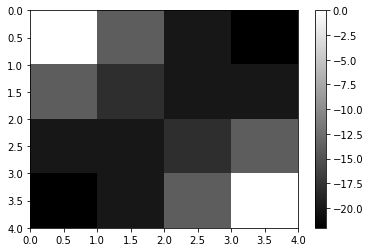

In [8]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [9]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [10]:
def policy_improvement(env, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        
        V = policy_eval(policy, env, discount_factor)
        
        # YOUR CODE HERE
        policy_stable = True
        for current_state in range(env.nS):
            old_action = np.argmax(policy[current_state])

            q_sa = np.zeros(env.nA)
            for (action, transitions) in env.P[current_state].items():
                for (transition_prob, next_state, reward, done) in transitions:
                    q_sa[action] += transition_prob * (reward + discount_factor * V[next_state])

            # ties broken consistently
            greedy_action = np.argmax(q_sa)
            greedy_policy = np.zeros(env.nA, dtype=np.float)
            greedy_policy[greedy_action] = 1.0
            policy[current_state] = greedy_policy
            
            # ties broken arbitrarily
            
            

            if greedy_action != old_action:
                policy_stable = False
        if policy_stable:
            break;
    return policy, V

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



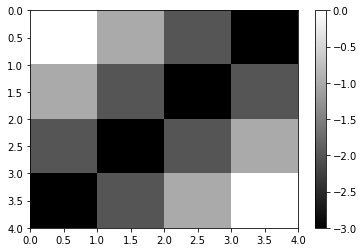

In [11]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [12]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [13]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.    
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    
    # Implement!
    # YOUR CODE HERE
    while True:    
        delta = 0
        for current_state in range(env.nS):
            v = V[current_state]
            
            q_sa = np.zeros(env.nA)
            for (action, transitions) in env.P[current_state].items():
                for (transition_prob, next_state, reward, done) in transitions:
                    q_sa[action] = transition_prob * (reward + discount_factor * V[next_state])
            
            V[current_state] = np.max(q_sa)
            
            policy[current_state] = np.zeros(env.nA)
            policy[current_state][np.argmax(q_sa)] = 1
            
            delta = max(delta, abs(v - V[current_state]))
        if delta < theta:
            break
    
    return policy, V

In [14]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

---

**ANSWER**

The difference between the policy iteration and value iteration algorithms lies in the policy evaluation step. Policy iteration estimates the state values as an expectation over all possible states and all possible actions. Value iteration estimates the state values by just looking at the next action that gives the highest expected return. Policy iteration evaluates the policy until convergence of the state values, while value iteration truncates this evaluation to only a single step. Value iteration is most efficient because it performs one backup operation from the greedy action only, as opposed to policiy iteration which performs backups from all possible states. In other words, in value iteration, the policy evaluation is stopped after one sweep, whereas in policy iteration it is stopped after multiple sweeps.

---

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

---

**ANSWER**

Dynamic Programming uses bootstrapping to estimate state values, i.e. it uses estimates of the future states. The Monte Carlo estimates of state values is based only on experience, so it does not use estimates in the estimation process, it uses samples. Dynamic Programming needs a full model of the environment because it makes use of the transition probabilities. Monte Carlo does not since it uses only experience, but expects the task to be split in episodes, i.e. it expects an eventual terminal state. 

Dynamic Programming is useful in online learning situations when we have a full model of the environment because it does not require episodic tasks. Monte Carlo is useful when we do not have a full model of the environment. Monte Carlo is also useful when we can simulate the environment to draw experience, or when we want to focus on just a particular state.

---

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [15]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [16]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

Init signature: gym.Env()
Docstring:     
The main OpenAI Gym class. It encapsulates an environment with
arbitrary behind-the-scenes dynamics. An environment can be
partially or fully observed.

The main API methods that users of this class need to know are:

    step
    reset
    render
    close
    seed

And set the following attributes:

    action_space: The Space object corresponding to valid actions
    observation_space: The Space object corresponding to valid observations
    reward_range: A tuple corresponding to the min and max possible rewards

Note: a default reward range set to [-inf,+inf] already exists. Set it if you want a narrower range.

The methods are accessed publicly as "step", "reset", etc.. The
non-underscored versions are wrapper methods to which we may add
functionality over time.
File:           ~/miniconda3/envs/rl2018/lib/python3.6/site-packages/gym/core.py
Type:           type


In [17]:
# We can also look at the documentation/implementation of a method
?env.step

Signature: env.step(action)
Docstring:
Run one timestep of the environment's dynamics. When end of
episode is reached, you are responsible for calling `reset()`
to reset this environment's state.

Accepts an action and returns a tuple (observation, reward, done, info).

Args:
    action (object): an action provided by the environment

Returns:
    observation (object): agent's observation of the current environment
    reward (float) : amount of reward returned after previous action
    done (boolean): whether the episode has ended, in which case further step() calls will return undefined results
    info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
File:      ~/Code/AI/rl-labs/lab1/blackjack.py
Type:      method


In [18]:
??BlackjackEnv

Init signature: BlackjackEnv(natural=False)
Source:        
class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [19]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    # YOUR CODE HERE
    return int(observation[0] < 20)

In [20]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(21, 6, True)
((21, 6, True), 1, True, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [21]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    # YOUR CODE HERE
    for i in tqdm(range(num_episodes)):
        # Generate an episode
        episode = []
        done = False
        observation = env.reset()
        
        # Store a sequence of observations for first-visit update
        observations= []
        
        while not done:
            # Store the seen observation
            observations.append(observation)
            
            # Generate a step in the episode
            step = [observation]
            action = simple_policy(observation)
            step.append(action)
            (observation, reward, done, _) = env.step(action)
            step.append(reward)
            episode.append(step)
        
        # Estimate V
        G = 0
        for (t, [observation, action, reward]) in reversed(list(enumerate(episode))):
            G = discount_factor * G + reward
            if observation not in observations[:t]:
                returns_sum[observation] += G
                returns_count[observation] += 1
                V[observation] = returns_sum[observation] / returns_count[observation]
    
    return V

In [22]:
a = [(1,2,3), (3,4,5)]
b = (1,2,3)
b not in a

False

In [23]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
print(V)

100%|██████████| 1000/1000 [00:00<00:00, 16172.87it/s]

defaultdict(<class 'float'>, {(15, 10, False): -0.5238095238095238, (16, 10, False): -0.6326530612244898, (14, 10, False): -0.717948717948718, (15, 1, False): -0.6363636363636364, (12, 1, False): -0.5, (20, 1, False): -0.23529411764705882, (14, 1, False): -0.7, (18, 2, False): -0.88, (17, 2, False): -0.7647058823529411, (16, 2, False): -0.3333333333333333, (19, 7, False): -0.5714285714285714, (16, 7, False): -1.0, (15, 3, False): -1.0, (18, 3, False): -0.7777777777777778, (20, 5, False): 0.5833333333333334, (21, 5, False): 0.8571428571428571, (13, 5, False): -0.3333333333333333, (20, 10, False): 0.3918918918918919, (20, 9, False): 0.7142857142857143, (21, 8, False): 0.8888888888888888, (18, 8, False): -0.5384615384615384, (13, 2, False): -0.7777777777777778, (13, 2, True): -0.3333333333333333, (16, 4, False): -0.8, (20, 7, False): 1.0, (17, 7, False): -0.46153846153846156, (20, 4, False): 0.5714285714285714, (20, 10, True): 0.625, (15, 4, False): -1.0, (13, 3, False): -0.75, (21, 3, Tr

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [24]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|██████████| 500000/500000 [00:25<00:00, 19337.29it/s]

CPU times: user 26.4 s, sys: 40.7 ms, total: 26.4 s
Wall time: 26.4 s


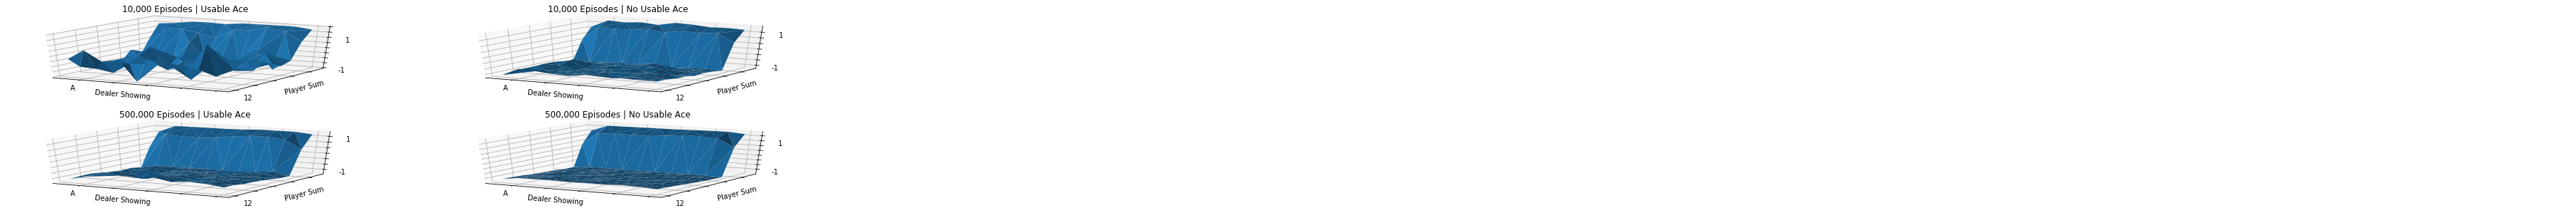

In [25]:
data = {
    '10k': {
        'ace': {
            'player_sum': [],
            'dealer_showing': [],
            'values': []
        },
        'no_ace': {
            'player_sum': [],
            'dealer_showing': [],
            'values': []
        }
    },
    '500k': {
        'ace': {
            'player_sum': [],
            'dealer_showing': [],
            'values': []
        },
        'no_ace': {
            'player_sum': [],
            'dealer_showing': [],
            'values': []
        }
    }
}

def collect_data(data, observation, value, run):
    player_sum, dealer_showing, ace = observation
    if ace:
        data[run]['ace']['player_sum'].append(player_sum)
        data[run]['ace']['dealer_showing'].append(dealer_showing)
        data[run]['ace']['values'].append(value)
    else:
        data[run]['no_ace']['player_sum'].append(player_sum)
        data[run]['no_ace']['dealer_showing'].append(dealer_showing)
        data[run]['no_ace']['values'].append(value)
        
def plot_data(data, run, ace, ax):
    titles = {
        ('10k', 'ace'): '10,000 Episodes | Usable Ace',
        ('10k', 'no_ace'): '10,000 Episodes | No Usable Ace',
        ('500k', 'ace'): '500,000 Episodes | Usable Ace',
        ('500k', 'no_ace'): '500,000 Episodes | No Usable Ace'
    }
    
    player_sum = np.array(data[run][ace]['player_sum'])
    dealer_showing = np.array(data[run][ace]['dealer_showing'])
    value = np.array(data[run][ace]['values'])
    
    ax.plot_trisurf(dealer_showing, player_sum, value, shade=True)

    xticklabels = ax.get_xticklabels()
    new_xticklabels = [None] * len(xticklabels)
    new_xticklabels[0] = 'A'
    new_xticklabels[-1] = '12'
    ax.set_xticklabels(new_xticklabels)
    
    yticklabels = ax.get_yticklabels()
    new_yticklabels = [None] * len(yticklabels)
    new_yticklabels[0] = '12'
    new_yticklabels[-1] = '21'
    ax.set_yticklabels(new_yticklabels)
    
    zticklabels = ax.get_yticklabels()
    new_zticklabels = [None] * len(zticklabels)
    new_zticklabels[0] = '-1'
    new_zticklabels[-1] = '1'
    ax.set_zticklabels(new_zticklabels)
    
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    
    ax.set_title(titles[(run, ace)])


for observation, value in V_10k.items():
    collect_data(data, observation, value, '10k')

for observation, value in V_500k.items():
    collect_data(data, observation, value, '500k')
    
from mpl_toolkits import mplot3d
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': '3d'}, figsize=(20, 5))
plot_data(data, '10k', 'ace', axes[0][0])
plot_data(data, '10k', 'no_ace', axes[0][1])
plot_data(data, '500k', 'ace', axes[1][0])
plot_data(data, '500k', 'no_ace', axes[1][1])

## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy.

In [26]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        action_values = Q[observation]
        # ties broken consistentnly
        # greedy_action = np.argmax(action_values)
        
        # ties broken arbitrarily
        greedy_actions = action_values == np.max(action_values)
        count_greedy_actions = sum(greedy_actions)
        
        greedy_action_probs = greedy_actions.astype(np.int) / count_greedy_actions
        greedy_action = np.random.choice(np.arange(nA), p=greedy_action_probs)
        
        action_probs = np.array([epsilon / nA] * nA)
        action_probs[greedy_action] = 1 - epsilon + epsilon / nA
        
        return action_probs
    
    return policy_fn

In [27]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    
    # YOUR CODE HERE
    for i in tqdm(range(num_episodes)):
        # Generate an episode
        episode = []
        done = False
        observation = env.reset()
        observations_actions = []
        while not done:
            # Generate step
            step = [observation]
            action = np.random.choice(np.arange(env.nA), p=policy(observation))
            
            # Store S,A pais for first-visit control
            observations_actions.append((observation, action))
            
            # Continue with step generation
            step.append(action)
            (observation, reward, done, _) = env.step(action)
            step.append(reward)
            episode.append(step)
        
        # Estimate Q
        G = 0
        for (t, [observation, action, reward]) in reversed(list(enumerate(episode))):
            G = discount_factor * G + reward
            if (observation, action) not in observations_actions[:t]:
                returns_sum[observation][action] += G
                returns_count[observation][action] += 1
                Q[observation][action] = returns_sum[observation][action] / returns_count[observation][action]

    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

100%|██████████| 10000/10000 [00:01<00:00, 5635.73it/s]


In [28]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [01:27<00:00, 5707.92it/s]

CPU times: user 1min 26s, sys: 4.93 s, total: 1min 31s
Wall time: 1min 27s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

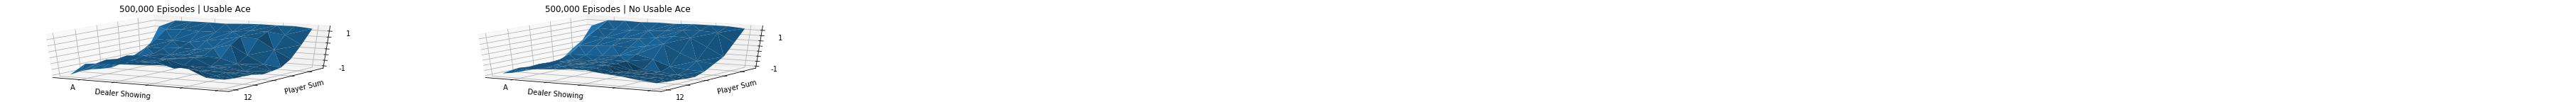

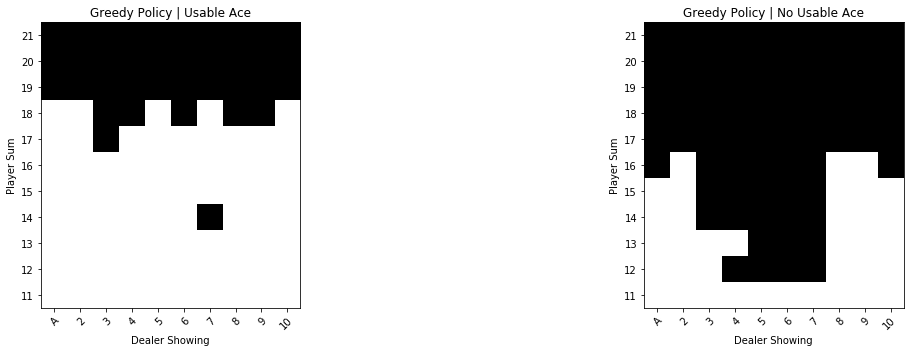

In [29]:
# YOUR CODE HERE
V = defaultdict(float)
for observation in Q:
    action = np.argmax(Q[observation])
    V[observation] = Q[observation][action]

data = {
    '500k': {
        'ace': {
            'player_sum': [],
            'dealer_showing': [],
            'values': []
        },
        'no_ace': {
            'player_sum': [],
            'dealer_showing': [],
            'values': []
        }
    }
}
for (observation, value) in V.items():
    collect_data(data, observation, value, '500k')
    
player_sum = np.array(data['500k']['ace']['player_sum'])
dealer_showing = np.array(data['500k']['ace']['dealer_showing'])
values = np.array(data['500k']['ace']['values'])

plt.figure(figsize=(20,5))
ax = plt.subplot(221, projection='3d')
plot_data(data, '500k', 'ace', ax)
ax = plt.subplot(222, projection='3d')
plot_data(data, '500k', 'no_ace', ax)


ace_greedy_actions = np.empty((11, 10))
ace_greedy_actions[0] = 1
no_ace_greedy_actions = np.empty((11, 10))
no_ace_greedy_actions[0] = 1
for (observation, action_values) in Q.items():
    (player_sum, dealer_showing, ace) = observation
    action = np.argmax(action_values)
    
    if ace:
        ace_greedy_actions[player_sum - 11, dealer_showing - 10] = action
    else:
        no_ace_greedy_actions[player_sum - 11, dealer_showing - 10] = action

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

ax[0].imshow(ace_greedy_actions, cmap='gray', origin='lower')
ax[0].set_xticks(np.arange(10))
ax[0].set_yticks(np.arange(11))
ax[0].set_xlabel('Dealer Showing')
xticklabels = ['A'] + list(range(2,11))
ax[0].set_xticklabels(xticklabels)
ax[0].set_yticklabels(list(range(11,22)))
ax[0].set_ylabel('Player Sum')
ax[0].set_title("Greedy Policy | Usable Ace")
plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax[1].imshow(no_ace_greedy_actions, cmap='gray', origin='lower')
ax[1].set_xticks(np.arange(10))
ax[1].set_yticks(np.arange(11))
ax[1].set_xlabel('Dealer Showing')
xticklabels = ['A'] + list(range(2,11))
ax[1].set_xticklabels(xticklabels)
ax[1].set_yticklabels(list(range(11,22)))
ax[1].set_ylabel('Player Sum')
ax[1].set_title("Greedy Policy | No Usable Ace")
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fig.tight_layout()

## 6. Temporal Difference (TD) learning (8 points)
Mention one advantage and one disadvantage of Monte Carlo methods. Mention an example where you would prefer to use TD learning.

---

**ANSWER**
As an advantage, Monte Carlo can quickly back-up from a single episode. However, Monte-Carlo needs a full episode before it can update the value / action-value function. In the case where there are no episodes, or episodes are particularly lengthy, or we cannot simulate but only exprience in real tasks (online learning), TD is preferred.

---

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. In other words: implement SARSA. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [30]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

100%|██████████| 1000/1000 [00:02<00:00, 373.65it/s]


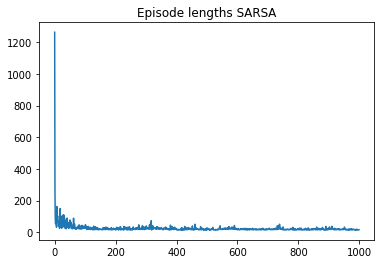

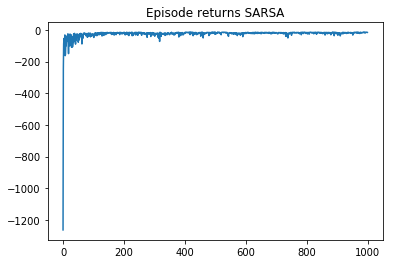

In [31]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        state = env.reset()
        action = np.random.choice(np.arange(env.nA), p=policy(state))
        done = False
        
        while not done:
            old_state = state
            old_action = action
            (state, reward, done, _) = env.step(action)
            action = np.random.choice(np.arange(env.nA), p=policy(state))
            Q[old_state][old_action] += alpha * (reward + discount_factor * Q[state][action] - Q[old_state][old_action])
            
            R += discount_factor ** i * reward
            i += 1
            
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_sarsa)
plt.title('Episode lengths SARSA')
plt.show()

plt.plot(episode_returns_sarsa)
plt.title('Episode returns SARSA')
plt.show()

Since we might not be interested in falling off the cliff all the time, we can find another person to do this 'exploration' for us (in the name of science). Still, we would like to learn ourselfs from this persons policy, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

100%|██████████| 1000/1000 [00:02<00:00, 438.12it/s]


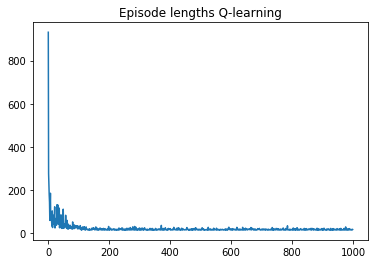

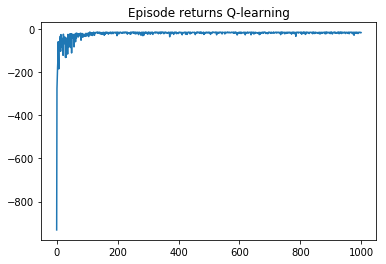

In [32]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        state = env.reset()
        action = np.random.choice(np.arange(env.nA), p=policy(state))
        done = False
        
        while not done:
            old_state = state
            old_action = action
            
            (state, reward, done, _) = env.step(action)
            action = np.random.choice(np.arange(env.nA), p=policy(state))
            
            Q[old_state][old_action] += alpha * (reward + discount_factor * np.max(Q[state]) - Q[old_state][old_action])
            
            R += discount_factor ** i * reward
            i += 1
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

Now compare the episode returns while learning for Q-learning and Sarsa (maybe run some more iterations?), by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, you may want to zoom in on the y-axis and smooth the returns (e.g. plotting the $n$ episode average instead). Which algorithm achieves higher return during learning? How does this compare to Example 6.6 from the book? Try to explain your observations.

In [33]:
# YOUR CODE HERE
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 10000)
Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 10000)

100%|██████████| 10000/10000 [00:19<00:00, 512.66it/s]


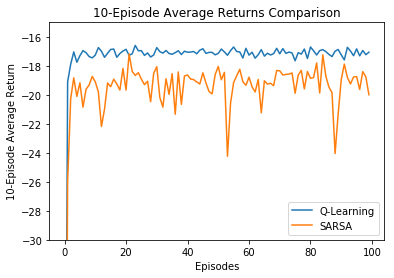

In [34]:
ql_len = np.array(episode_lengths_q_learning)
ql_ret = np.array(episode_returns_q_learning)
sarsa_len = np.array(episode_lengths_sarsa)
sarsa_ret = np.array(episode_returns_sarsa)

ql_ret_10avg = ql_ret.reshape(100,100).mean(axis=1)
sarsa_ret_10avg = sarsa_ret.reshape(100,100).mean(axis=1)

plt.plot(ql_ret_10avg, label="Q-Learning")
plt.plot(sarsa_ret_10avg, label="SARSA")
plt.title('10-Episode Average Returns Comparison')
plt.ylabel('10-Episode Average Return')
plt.xlabel('Episodes')
plt.ylim((-30, -15))
plt.legend()
plt.show()

---

**ANSWER**

Q-Learning consistently achieves higher reward on average in this case. This is because Q-learning learn a greedy policy, while SARSA learns an $\epsilon$-greedy policy. Because in our case, the greedy action is always the best action to take, this results in Q-learning achieving higher and more stable returns.

This is the opposite result as compared to the Cliff Walking example in the book. This makes sense, because in our case there is no danger of a very low reward, so there is no use in taking randomness into account to learn a safer policy. In other words, because SARSA learns a policy which sometimes does not point in the direction of the goal, it will be less optimal since the only thing that determines our episode return is how long it takes to get to the goal.

---

After we have learned the policy, we do not care about exploration any more and we may switch to a deterministic (greedy) policy instead. If we evaluate this for both Sarsa and Q-learning (actually, for Q-learning the learned policy is already deterministic), which policy would you expect to perform better? Why?

---

**ANSWER**

I would expect that both behave the same in the non-exploring case. SARSA learns an $\epsilon$-greedy policy, but the most probable action under the policy should still be the greedy one, so one would expect that both SARSA and Q-Learning obtain the same greedy policy. It is possible that SARSA might still learn a suboptimal policy because of its exploration component, but the policy should converge toward the optimal policy as the number of episodes increases. Looking at the comparison between Q-learning and SARSA above, one can imagine that if we stop the algorithm at a point where SARSA achieves a low avearge reward, the learned policy will not be close to optimal, so we might obtain non-optimal paths.

Since we are using a greedy policy for evaluation, one run is sufficient for evaluation, since everyhting is deterministic. Still, note that for different learned Q functions, the results might differ slightly. In particular, sometime SARSA requires 16 steps to finish an episode because of the exploration component

---

Please run the experiments to test your hypothesis (print or plot your results). How many runs do you need to evaluate the policy? Note: without learning, the order of the episodes is not relevant so a normal `plt.plot` may not be the most appropriate choice.

In [35]:
def eval_method_greedy(Q, discount_factor=1.00):
    stats = []
    
    i = 0
    R = 0

    state = env.reset()
    done = False
    while not done:
        action = np.argmax(Q[state])
        (state, reward, done, _) = env.step(action)

        R += discount_factor ** i * reward
        i += 1
    
    return (i, R)

In [36]:
qlen_len, qlen_ret = eval_method_greedy(Q_q_learning)
sarsa_len, sarsa_ret = eval_method_greedy(Q_sarsa)

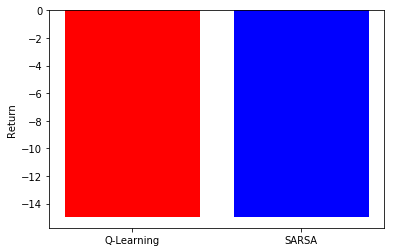


Q-Learning:
    Episode Length: 15
    Episode Return: -15.0
SARSA:
    Epsiode Length: 15
    Episode Return: -15.0



In [37]:
fig, ax = plt.subplots()
q, s = plt.bar([1,2], [qlen_ret, sarsa_ret])
q.set_facecolor('r')
s.set_facecolor('b')
ax.set_ylabel('Return')
ax.set_xticks([1,2])
ax.set_xticklabels(['Q-Learning', 'SARSA'])

plt.show()

s = """
Q-Learning:
    Episode Length: {}
    Episode Return: {}
SARSA:
    Epsiode Length: {}
    Episode Return: {}
""".format(qlen_len, qlen_ret, sarsa_len, sarsa_ret)
print(s)